In [6]:
import os
import logging
os.environ.setdefault('TF_CPP_MIN_LOG_LEVEL', '0')
os.environ.setdefault('TF_XLA_FLAGS', '--tf_xla_enable_xla_devices')

import tensorflow as tf
from tensorflow_addons.callbacks import TQDMProgressBar
from config import DATASET_PATH, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS, BATCH_SIZE
from keras.utils import image_dataset_from_directory
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, BatchNormalization
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras import mixed_precision
from matplotlib import pyplot as plt

In [2]:
logger = tf.get_logger()
logger.setLevel(logging.DEBUG)
mixed_precision.set_global_policy(mixed_precision.Policy('mixed_float16'))
tf.config.experimental.list_physical_devices()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

# Load data

In [3]:
seed = 314
epochs = 15

ds = [
    image_dataset_from_directory(
        DATASET_PATH,
        validation_split=0.2,
        subset=subset,
        seed=seed,
        image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=BATCH_SIZE,
    )
    for subset in ['training', 'validation']
]
train_ds, val_ds = ds

class_names = train_ds.class_names
num_classes = len(class_names)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print(class_names)

Found 2477 files belonging to 5 classes.
Using 1982 files for training.
Found 2477 files belonging to 5 classes.
Using 495 files for validation.
['CHAERYEONG', 'LIA', 'RYUJIN', 'YEJI', 'YUNA']


# Define model

In [15]:
Augmentation = lambda: Sequential(
    [
        RandomFlip('horizontal'),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ],
    name='augmentation',
)

model = Sequential(
    [
        Augmentation(),
        Rescaling(scale=1/255, name='rescale'),
        Conv2D(filters=96, kernel_size=7, strides=2, name='conv1'),
        MaxPooling2D(pool_size=3, strides=2, name='pool1'),
        Conv2D(filters=256, kernel_size=5, strides=2, name='conv2'),
        MaxPooling2D(pool_size=3, strides=2, name='pool2'),
        Conv2D(filters=384, kernel_size=3, name='conv3'),
        Conv2D(filters=384, kernel_size=3, name='conv4'),
        Conv2D(filters=256, kernel_size=3, name='conv5'),
        MaxPooling2D(pool_size=3, strides=2, name='pool3'),
        Flatten(),
        Dense(4096, name='fc1'),
        Dense(4096, name='fc2'),
        Dense(num_classes, activation='softmax', name='output'),
    ],
    name="kvision-0.1.0",
)

In [16]:
model.compile(
    optimizer='sgd',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.build(input_shape=(None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

model.summary()

Model: "kvision-0.1.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescale (Rescaling)         (None, 224, 224, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 109, 109, 96)      14208     
                                                                 
 pool1 (MaxPooling2D)        (None, 54, 54, 96)        0         
                                                                 
 conv2 (Conv2D)              (None, 25, 25, 256)       614656    
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 12, 256)       0         
                                                                 
 conv3 (Conv2D)              (None, 10, 10, 384)     

# Training

In [7]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[TQDMProgressBar(leave_epoch_progress=False, leave_overall_progress=True)],
    verbose=False,
)

Training:   0%|                                                                                               …

Epoch 1/15


0/16                                                                                                          …

Epoch 2/15


0/16                                                                                                          …

Epoch 3/15


0/16                                                                                                          …

Epoch 4/15


0/16                                                                                                          …

Epoch 5/15


0/16                                                                                                          …

Epoch 6/15


0/16                                                                                                          …

Epoch 7/15


0/16                                                                                                          …

Epoch 8/15


0/16                                                                                                          …

Epoch 9/15


0/16                                                                                                          …

Epoch 10/15


0/16                                                                                                          …

Epoch 11/15


0/16                                                                                                          …

Epoch 12/15


0/16                                                                                                          …

Epoch 13/15


0/16                                                                                                          …

Epoch 14/15


0/16                                                                                                          …

Epoch 15/15


0/16                                                                                                          …

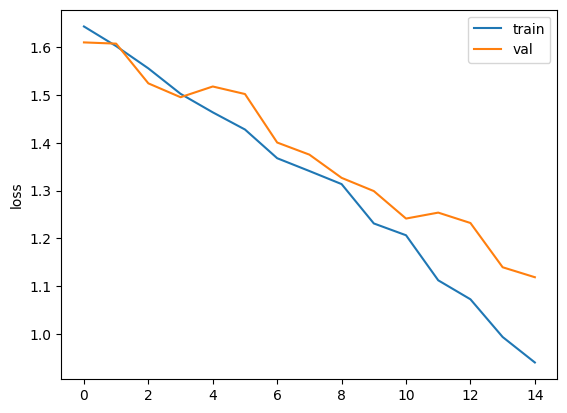

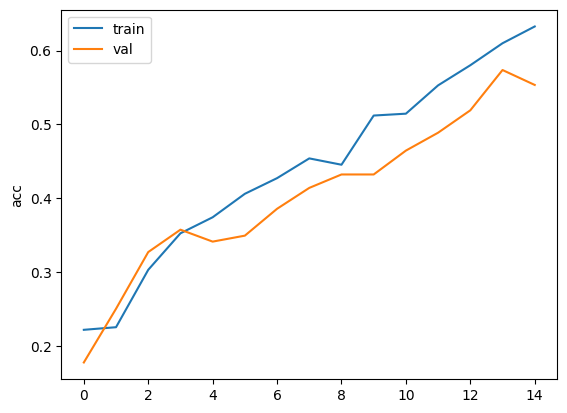

In [8]:
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='val')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history.epoch, history.history['accuracy'], label='train')
plt.plot(history.epoch, history.history['val_accuracy'], label='val')
plt.ylabel('acc')
plt.legend()
plt.show()

In [9]:
model.evaluate(val_ds.take(1))

1/1 [==============================] - 0s 135ms/step - loss: 1.1934 - accuracy: 0.5391


[1.193359375, 0.5390625]

In [10]:
test = next(iter(val_ds))[0][0]
test = tf.expand_dims(test, 0)
predictions = model.predict(test)

1/1 [==============================] - 0s 94ms/step


In [11]:
score = tf.nn.relu(predictions[0])
class_names[np.argmax(score)]

'CHAERYEONG'

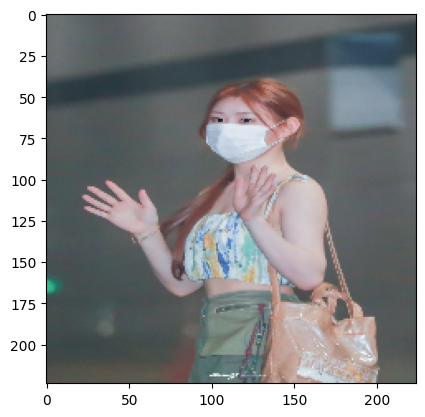

In [12]:
plt.imshow(test[0]/255)
plt.show()